In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from utils import set_seed
from plot_utils import plot_eval_results

set_seed()


In [16]:

from mnist_utils import plot_samples
from config import cfg
from vanilla_model import fit as fit_vanilla
from metrics import calc_metrics
from converters import Converter
from config import cfg
from eval import run_tflite_model
from c_utils import write_model_h
from utils import save_test_data
import plot_utils as pu

In [17]:
from nyuv2_torch_ds_adapter import get_tf_nyuv2_ds
import argparse
args = argparse.Namespace()
args.truncate_testset = False
# args.target_size = (64, 64)
args.crop_size = (640, 480)
# args.target_size = (64, 64)
args.target_size = cfg.img_size
args.out_fold_ratio = 1
args.is_maxim = False
ds_train, ds_val, ds_test = get_tf_nyuv2_ds(cfg.base_kitti_dataset_dir, args)
# x=next(iter(ds_train.shuffle(100).batch(2).take(1)))
# pu.plot_sample_nyuv2(x)
train_size=cfg.take_first_n
ds_train = ds_train.batch(cfg.batch_size).take(train_size)
val_size=cfg.take_first_n
ds_val = ds_val.batch(cfg.batch_size).take(val_size)
test_size=cfg.take_first_n
ds_test = ds_test.batch(cfg.batch_size).take(test_size)

x_val= next(iter(ds_val))
x_train= next(iter(ds_train))
x_test= next(iter(ds_test))

Dataset: NYU Depth V2
# of train images: 50688
Dataset: NYU Depth V2
# of test images: 654
Train size:  40551
Val size:  10137
Test size:  654


-0.2409375 -0.17124999
-0.2440625 -0.21749999
0.313125 0.8680859


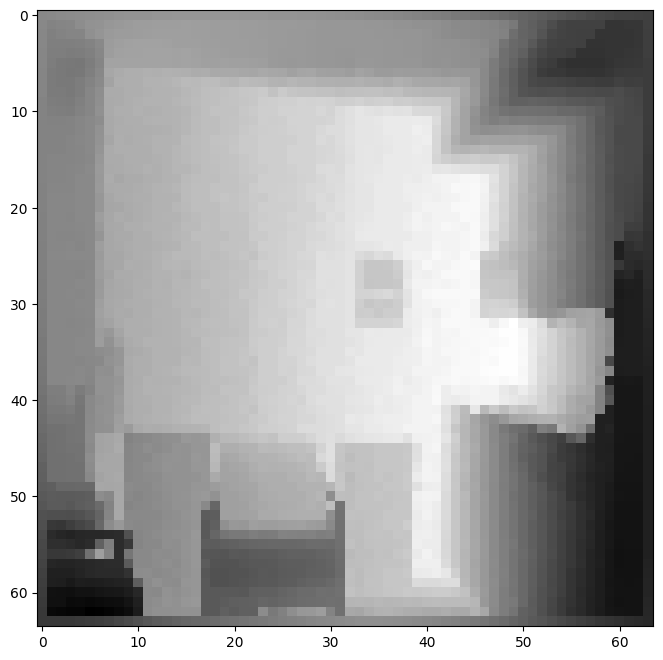

In [18]:
print(x_train[1].numpy().min(), x_train[1].numpy().max())
print(x_val[1].numpy().min(), x_val[1].numpy().max())
print(x_test[1].numpy().min(), x_test[1].numpy().max())
plt.imshow(x_test[1][0].numpy().squeeze())

In [27]:
from loss import calculate_loss
from model import get_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

keras.backend.clear_session()
# loss = tf.keras.losses.MeanSquaredError()
metrics = tf.keras.metrics.Mean(name="loss")
mae_loss = tf.keras.losses.MeanAbsoluteError()


# Define a custom metric
def custom_metric(y_true, y_pred, sample_weight=None):
    return mae_loss(y_true, y_pred, sample_weight=sample_weight)
    metric_value = calculate_loss(y_true, y_pred)
    metrics.update_state(metric_value, sample_weight=sample_weight)
    # return {"loss2": metrics.result()}
    # return metric_value


# Build model
model = get_model(
    cfg.img_size, cfg.num_classes, in_channels=cfg.in_channels, use_qat=False
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="mae", metrics=[custom_metric])

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.2, min_lr=1e-7, patience=5, min_delta=1e-2, verbose=1
)
callbacks = [reduce_lr]
if not cfg.do_overfit:
    tbCallBack = tf.keras.callbacks.TensorBoard(
        log_dir=f"{cfg.logdir}/tb_logs",
        histogram_freq=0,
        write_graph=False,
        write_images=False,
    )
    es = tf.keras.callbacks.EarlyStopping(
        patience=cfg.es_patience, restore_best_weights=True
    )
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=cfg.logdir + "/best_model.h5",
        save_weights_only=True,
        monitor="custom_metric",
        mode="min",
        save_best_only=True,
    )
    callbacks.append(es)
    callbacks.append(model_checkpoint_callback)
    callbacks.append(tbCallBack)

history = model.fit(
    x=ds_train,
    epochs=200,
    validation_data=ds_val,
    batch_size=1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.9587 - custom_metric: 0.9587 - val_loss: 0.2309 - val_custom_metric: 0.2309 - lr: 1.0000e-04
Epoch 2/200
1/1 [==============================] - 0s 82ms/step - loss: 0.9124 - custom_metric: 0.9124 - val_loss: 0.2220 - val_custom_metric: 0.2220 - lr: 1.0000e-04
Epoch 3/200
1/1 [==============================] - 0s 63ms/step - loss: 0.8811 - custom_metric: 0.8811 - val_loss: 0.2174 - val_custom_metric: 0.2174 - lr: 1.0000e-04
Epoch 4/200
1/1 [==============================] - 0s 60ms/step - loss: 0.8564 - custom_metric: 0.8564 - val_loss: 0.2142 - val_custom_metric: 0.2142 - lr: 1.0000e-04
Epoch 5/200
1/1 [==============================] - 0s 63ms/step - loss: 0.8357 - custom_metric: 0.8357 - val_loss: 0.2107 - val_custom_metric: 0.2107 - lr: 1.0000e-04
Epoch 6/200
1/1 [==============================] - 0s 59ms/step - loss: 0.8250 - custom_metric: 0.8250 - val_loss: 0.2075 - val_custom_metric: 0.2075 - lr: 1.0000e-04


1/1 [==============================] - 0s 250ms/step
MAE: 0.44, RMSE: 0.26, loss: 0.89


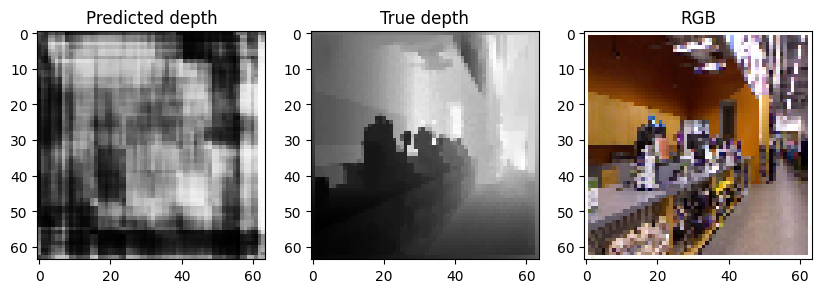

In [28]:
out = model.predict(x_train[0])
plot_eval_results(out[0], x_train[1][0], x_train[0][0])

In [22]:
from eval import eval_model


metrics = eval_model(model, ds_test, tflite_path="/tmp/models/depth_full_quant.tflite", model_name="test",
                     metrics_file_path=f"{cfg.save_model_dir}/metrics.json")

# eval_model(model, ds_test, tflite_path="/tmp/models/pruned_qat_model.tflite", model_name="test")

test model metrics:
mse: 54330.258
mae: 232.218
eval_loss: 1.359
eval_metric: 1.049
Saved metrics to /media/master/wext/msc_studies/second_semester/microcontrollers/project/stm32/code/models/metrics.json


In [23]:
x_train[0].numpy().min(), x_train[0].numpy().max(), x_train[1].numpy().min(), x_train[1].numpy().max()

(0.0, 1.0, -0.2409375, -0.17124999)

In [12]:
model.evaluate(ds_test, batch_size=1, verbose=1)

7/7 [==============================] - 2s 295ms/step - loss: 1.3431 - custom_metric: 1.1518


[1.3430613279342651, 1.1517744064331055]

In [13]:
out.min(), out.max(), x_train[1][0].numpy().min(), x_train[1][0].numpy().max()

(-0.88279116, 0.17683801, -0.2409375, -0.17124999)

In [14]:
calculate_loss(out[0], x_train[1][0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5899138>